In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
from scipy.stats import fisher_exact
from scipy.stats import kstest, norm, ks_1samp

In [25]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [26]:
def draw_data(num_samples, mean, sigma):
    x = np.random.normal(mean, sigma, num_samples)
    return x

def loop(n, m, delta, sigma=1):
    in_data = draw_data(n, 0, sigma)
    out_data = draw_data(m, delta, sigma)
    mean_in = np.mean(in_data)
    mean_out = np.nanmean(out_data)
    comb_mean = (n*mean_in + m*mean_out)/(n+m)
    squared_err = comb_mean**2
    res = ks_1samp(out_data, norm.cdf)
    return squared_err, res.statistic, res.pvalue

In [47]:
n = 5
m_list = np.arange(1, 20, 1)
delta = 1
reps = 10000

risk_list = []
stat_list = []
p_list = []
for m in m_list:
    f = lambda : loop(n, m, delta)
    results = np.array(Parallel(n_jobs=-1)(delayed(f)() for i in range(reps)))
    risk_list.append(np.mean(results[:, 0]))
    stat_list.append(np.mean(results[:, 1]))
    p_list.append(np.mean(results[:, 2]))


Text(0, 0.5, 'MSE')

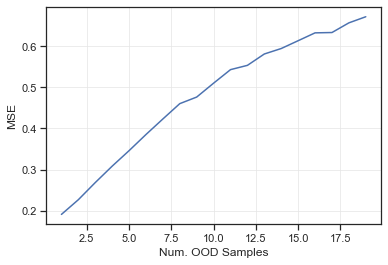

In [48]:
plt.plot(m_list, risk_list)
plt.xlabel("Num. OOD Samples")
plt.ylabel("MSE")

Text(0, 0.5, 'Mean Value of K-S Statistic')

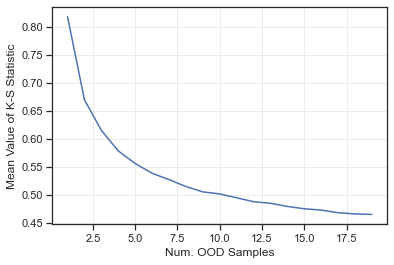

In [49]:
plt.plot(m_list, stat_list)
plt.xlabel("Num. OOD Samples")
plt.ylabel("Mean Value of K-S Statistic")

Text(0, 0.5, 'Mean p-value')

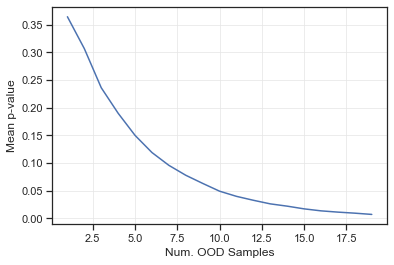

In [50]:
plt.plot(m_list, p_list)
plt.xlabel("Num. OOD Samples")
plt.ylabel("Mean p-value")